In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np 
from datetime import datetime, timedelta
import holidays

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pywt

In [2]:
tf.__version__

'2.4.1'

In [3]:
tf.test.is_gpu_available()

True

# Importing data and building dataset

In [4]:
data = pd.read_csv("/kaggle/input/poland-electricity-load/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric.set_index('Date', inplace=True)

In [5]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data.Date)
data.loc[data.Hour == 24, 'Date'] = data.loc[data.Hour == 24, 'Date'] + timedelta(days=1)
data.loc[data.Hour == 24, 'Hour'] = 0
data.Date = pd.to_datetime(data.Date.astype(str) + ' ' + data['Hour'].astype(str) + ':' + data.Minute.astype(str) + ':00')
data.set_index('Date', inplace=True)

fig_width_pt = 222.62206                # Get this from LaTeX using \the\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches

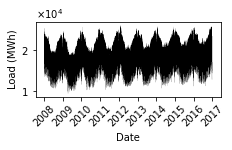

In [6]:
plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
plt.plot(data.Load, c='k', linewidth=0.1)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
#plt.title('Poland electricity consumption', fontsize=10)

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax = plt.gca()
ax.yaxis.set_major_formatter(formatter) 

plt.savefig('Poland_Load.png', dpi=2000, transparent=False)

# Denoising the signal

In [7]:
def wavelet_filter(data, wavelet='coif5', threshold=0.3):
    maxlev = pywt.dwt_max_level(len(data), wavelet)

    # Decompose into wavelet components, to the level selected
    coeffs = pywt.wavedec(data, wavelet, level=maxlev)

    # Apply threshold to detail coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], mode='soft', 
                                   value=threshold*max(coeffs[i]))
    
    # Multilevel 1D Inverse Discrete Wavelet Transform
    datarec = pywt.waverec(coeffs, wavelet)
    return datarec

Text(0.5, 1.0, 'De-noised signal using wavelet techniques')

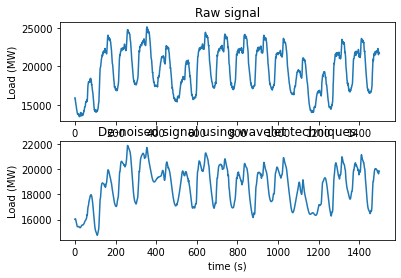

In [8]:
datarec = wavelet_filter(Electric.Load.to_numpy(), 'coif5', 0.3)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(Electric.Load.to_numpy()[:1500])
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title("Raw signal")
plt.subplot(2, 1, 2)
plt.plot(datarec[:1500])
plt.xlabel('time (s)')
plt.ylabel('Load (MW)')
plt.title("De-noised signal using wavelet techniques")

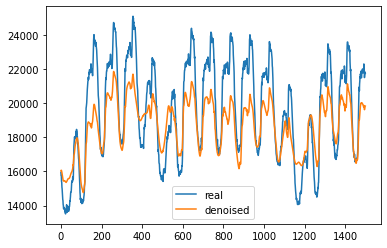

In [9]:
plt.plot(Electric.Load.to_numpy()[:1500], label='real')
plt.plot(datarec[:1500], label='denoised')
plt.legend()

In [10]:
Electric['Load_den'] = datarec
Electric

,Hour,Minute,Load,Load_den
Date,,,,
2008-01-01 00:15:00,0,15,15938.8,16033.102844
2008-01-01 00:30:00,0,30,15770.4,16065.937904
2008-01-01 00:45:00,0,45,15766.3,16072.117573
2008-01-01 01:00:00,1,0,15415.2,16048.723433
2008-01-01 01:15:00,1,15,15351.8,15999.161613
...,...,...,...,...
2016-12-31 23:00:00,23,0,15952.7,17706.769870
2016-12-31 23:15:00,23,15,15865.3,17666.932871
2016-12-31 23:30:00,23,30,15693.5,17624.806440


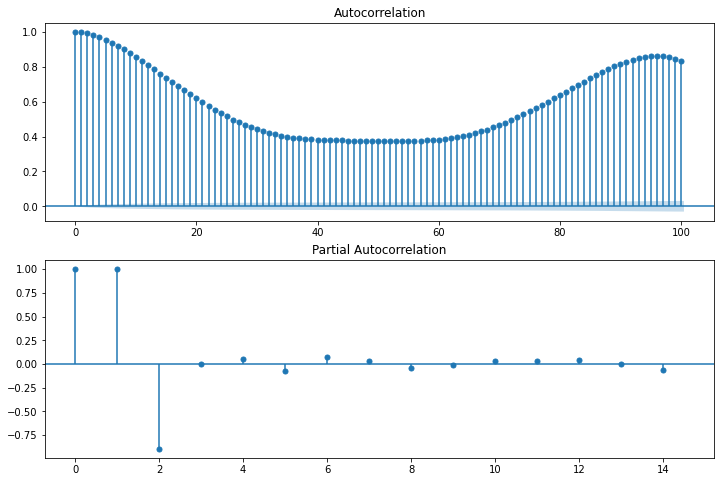

In [11]:
import statsmodels.api as sm 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lag = 100 # days 
fig = sm.graphics.tsa.plot_acf(Electric.Load_den, lags=lag, ax=ax1, fft=True)
ax2 = fig.add_subplot(212)
lag = 14
fig = sm.graphics.tsa.plot_pacf(Electric.Load_den, lags=lag, ax=ax2)

# Resampling the signal

In [12]:
resample_cost = 'd'
Electric_day = Electric.resample(resample_cost).agg({'Hour': np.mean, 'Minute': np.mean, 'Load_den': np.sum})
Electric_day.reset_index(inplace=True)
Electric_day.loc[Electric_day.Load_den < 20000, 'Load_den'] = np.nan
Electric_day.Load_den.interpolate(inplace=True)

Electric_day['Seconds'] = (Electric_day.Date - Electric_day.Date[0]).dt.total_seconds()
Electric_day = Electric_day[['Date', 'Seconds', 'Load_den']]
Electric_day['Day'] = Electric_day['Date'].dt.day_of_week
Electric_day['Minutes'] = Electric_day['Date'].dt.minute
Electric_day['Hour'] = Electric_day['Date'].dt.hour

In [13]:
Load_min, Load_max, Load_mean = Electric_day['Load_den'].min(), Electric_day['Load_den'].max(), Electric_day['Load_den'].mean() 
Electric_day['Load_den'] = (Electric_day['Load_den'] - Load_mean)/ (Load_max - Load_min) 

<AxesSubplot:>

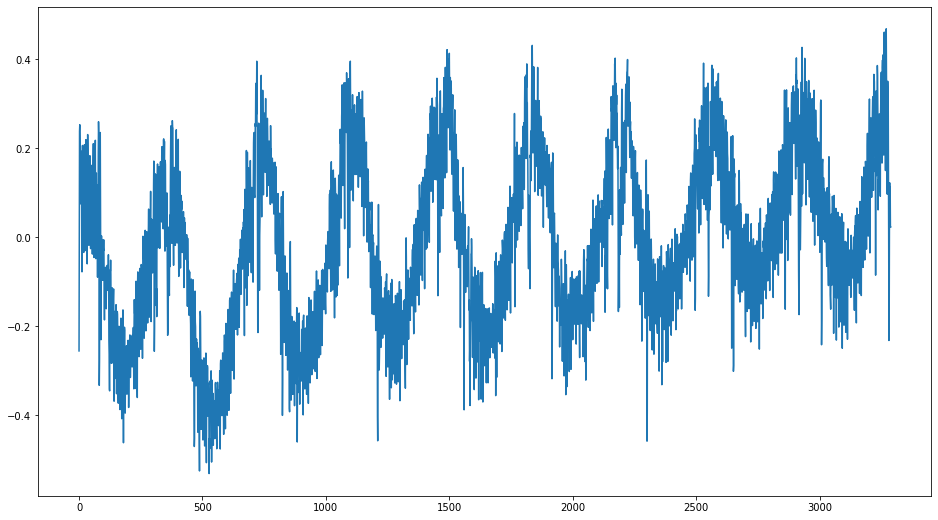

In [14]:
Electric_day.Load_den.plot(figsize=(16,9))

In [15]:
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    X, y = agg.iloc[:, :-n_out].values, agg.iloc[:, -n_out:].values
    return X, y

X, y = series_to_supervised(Electric_day.Load_den, 96, 1)
X, y

(array([[-0.25537752, -0.02017717,  0.23794248, ..., -0.0299233 ,
         -0.00615127, -0.07653822],
        [-0.02017717,  0.23794248,  0.25327984, ..., -0.00615127,
         -0.07653822, -0.0964288 ],
        [ 0.23794248,  0.25327984,  0.21056857, ..., -0.07653822,
         -0.0964288 , -0.02346279],
        ...,
        [-0.02645948,  0.11668573,  0.14049075, ...,  0.01523243,
          0.12266262,  0.06429987],
        [ 0.11668573,  0.14049075,  0.20491442, ...,  0.12266262,
          0.06429987,  0.1132849 ],
        [ 0.14049075,  0.20491442,  0.23380519, ...,  0.06429987,
          0.1132849 ,  0.02319255]]),
 array([[-0.0964288 ],
        [-0.02346279],
        [-0.02159558],
        ...,
        [ 0.1132849 ],
        [ 0.02319255],
        [ 0.02319255]]))

In [16]:
val_time = int(len(Electric_day.Load_den) * 0.80)
n_forecast = 14  
test_time = -n_forecast

# How much data from the past should we need for a forecast?
window_len = 96 # nearly 13 weeks
# How far ahead do we want to generate forecasts?
forecast_len = 1 # 1 day


batch_size = 32

training_data = Electric_day.iloc[:val_time]['Load_den']
validation_data = Electric_day.iloc[val_time:test_time]['Load_den']
test_data = Electric_day.iloc[test_time:]['Load_den']

X_train, y_train = series_to_supervised(training_data, 
                                        window_len, 
                                        forecast_len)

X_validation, y_validation = series_to_supervised(validation_data, 
                                        window_len, 
                                        forecast_len)

In [17]:
X_train, y_train = X_train.reshape(-1, 1, window_len), y_train.reshape(-1, 1, forecast_len)

X_validation, y_validation = X_validation.reshape(-1, 1, window_len), y_validation.reshape(-1, 1, forecast_len)

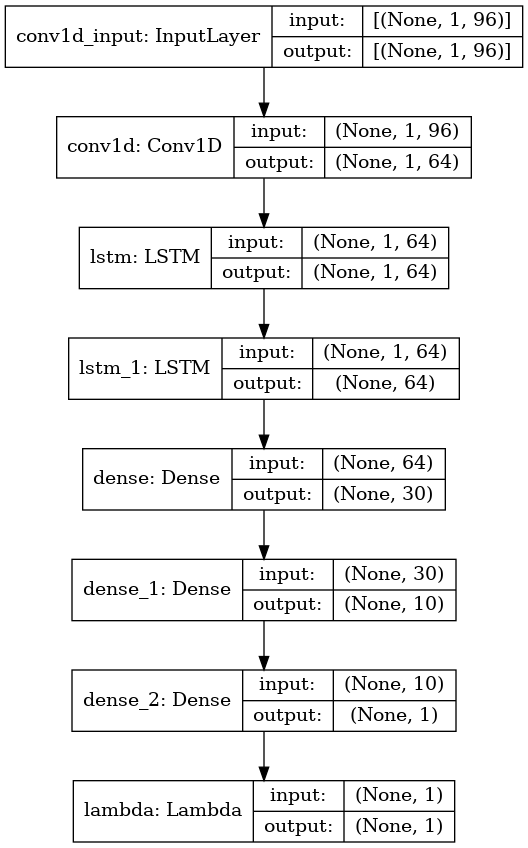

In [18]:
model_many_to_one = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu", input_shape=(1, window_len)),  # None = Model can take sequences of any length
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=False),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)  # LSTM's tanh activation returns between -1 and 1. Scaling output to same range of values helps learning.
])

# Note: to turn this into a classification task, just add a sigmoid function after the last Dense layer and remove Lambda layer.

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model_many_to_one.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to outliers
                          optimizer=optimizer,
                          metrics=["mae"])
tf.keras.utils.plot_model(model_many_to_one, show_shapes=True)

# Model building/training (point predictions)

In [19]:
model_many_to_one.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_validation, y_validation));

Epoch 1/100
80/80 [==============================] - 10s 20ms/step - loss: 0.0145 - mae: 0.1368 - val_loss: 0.0074 - val_mae: 0.0980
Epoch 2/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0077 - mae: 0.0979 - val_loss: 0.0081 - val_mae: 0.1037
Epoch 3/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0071 - mae: 0.0925 - val_loss: 0.0083 - val_mae: 0.1044
Epoch 4/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0066 - mae: 0.0895 - val_loss: 0.0071 - val_mae: 0.0952
Epoch 5/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0064 - mae: 0.0879 - val_loss: 0.0064 - val_mae: 0.0908
Epoch 6/100
80/80 [==============================] - 1s 8ms/step - loss: 0.0065 - mae: 0.0878 - val_loss: 0.0075 - val_mae: 0.0983
Epoch 7/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0058 - mae: 0.0847 - val_loss: 0.0090 - val_mae: 0.1091
Epoch 8/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0063 -

In [20]:
y_init = validation_data.values[-96:]
for i in range(14):
    v1 = model_many_to_one.predict(y_init[-window_len:].reshape(1,1,window_len))
    y_init = np.append(y_init, v1)

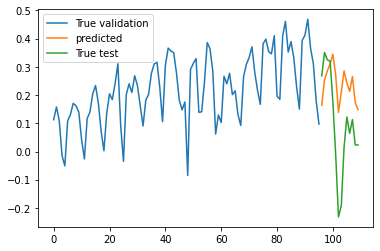

In [21]:
plt.plot(y_init[:window_len], label='True validation')
plt.plot(range(window_len, window_len + 14), y_init[window_len:], label='predicted')
plt.plot(range(window_len, window_len + 14), test_data.values, label='True test')
plt.legend()

# Forecasting with distributions

In [22]:
from tqdm import tqdm

def fit_model(X_train, y_train, X_validation, y_validation):
    features = X_train.shape[-1]
    model_many_to_one = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                             strides=1, padding="causal",
                             activation="relu", input_shape=(1, window_len)),  # None = Model can take sequences of any length
        tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(64, activation="tanh", return_sequences=False),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100)  # LSTM's tanh activation returns between -1 and 1. Scaling output to same range of values helps learning.
    ])

    # Note: to turn this into a classification task, just add a sigmoid function after the last Dense layer and remove Lambda layer.
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
    model_many_to_one.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to outliers
                              optimizer=optimizer,
                              metrics=["mae"])
    model_many_to_one.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_validation, y_validation), verbose=0)
    return model_many_to_one

    
def fit_ensemble(n_sim, X_train, y_train, X_validation, y_validation):
    ensemble = []
    for i in tqdm(range(n_sim)):
        model = fit_model(X_train, y_train, X_validation, y_validation)
        
        #store the models
        ensemble.append(model)
    return ensemble

def predictions(model, X_last, forecast_time, window_len):
    y_init = X_last[-window_len:]
    
    for i in range(forecast_time):
        v1 = model.predict(y_init[-window_len:].reshape(1,1,window_len))
        y_init = np.append(y_init, v1)
    
    return y_init
    

def ensemble_predictions(ensemble, X_last, forecast_time, window_len):
    pred = []
    for i, model in enumerate(ensemble):
        pred.append(predictions(model, X_last, forecast_time, window_len))
    
    pred = np.asarray(pred)
    y_hat = pred[:, -forecast_time:].mean(axis=0)
    interval = 1.96 * pred[:, -forecast_time:].std(axis=0)
    lower, upper = y_hat - interval, y_hat + interval
    return lower, y_hat, upper

In [23]:
ensemble = fit_ensemble(100, X_train, y_train, X_validation, y_validation)
X_test = validation_data.values[-window_len:]
lower, mean, upper = ensemble_predictions(ensemble, X_test, n_forecast, window_len)

100%|██████████| 100/100 [1:21:35<00:00, 48.95s/it]


Text(0, 0.5, 'Daily Load')

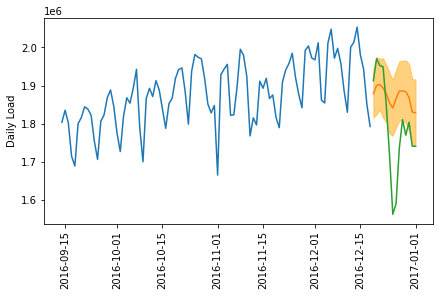

In [24]:
x = Electric_day.iloc[-(window_len + n_forecast):]['Date'].values

plt.figure(constrained_layout=True)
plt.plot(x[:-n_forecast], X_test * (Load_max - Load_min) + Load_mean, label='True validation')
plt.plot(x[-n_forecast:], mean * (Load_max - Load_min) + Load_mean, label='predicted')
plt.fill_between(x[-n_forecast:], y1=lower * (Load_max - Load_min) + Load_mean, 
                 y2=upper * (Load_max - Load_min) + Load_mean, label='CI 95%', color='orange', alpha=0.5)
plt.plot(x[-n_forecast:], test_data.values * (Load_max - Load_min) + Load_mean, label='True test')
plt.xticks(rotation='vertical')
plt.ylabel('Daily Load')

# Plotting results for the report

In [25]:
x = Electric_day.iloc[-(window_len + n_forecast):]['Date']
cols = ['Load_mean', 'Load_low', 'Load_up']
Electric_day.loc[Electric_day.Date.isin(x[-n_forecast:]), cols] = np.column_stack((mean, lower, upper))
Electric_day.to_csv('lstm_results.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


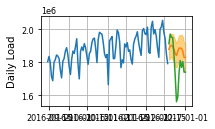

In [26]:
fig_width_pt = 222.62206                # Get this from LaTeX using \the\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

x = Electric_day.iloc[-(window_len + n_forecast):]['Date']

plt.figure(constrained_layout=True)
plt.plot(x[:-n_forecast], X_test * (Load_max - Load_min) + Load_mean, label='True validation')
plt.plot(x[-n_forecast:], mean * (Load_max - Load_min) + Load_mean, label='predicted')
plt.fill_between(x[-n_forecast:], y1=lower * (Load_max - Load_min) + Load_mean, 
                 y2=upper * (Load_max - Load_min) + Load_mean, label='CI 95%', color='orange', alpha=0.5)
plt.plot(x[-n_forecast:], test_data.values * (Load_max - Load_min) + Load_mean, label='True test')
#plt.xticks(rotation='vertical')
plt.ylabel('Daily Load')
plt.grid()
plt.tight_layout()
#plt.legend()
plt.savefig("./NN_LSTM_predictions.png", dpi=800, transparent=False)
